# Final Model

This notebook describes:

1. Setup (dependencies and imports)
2. Dataset (definitions of train and test sets)
3. Training (how the training was performed)
4. Error analysis (comparison with ground truths from test set and model results)
5. Export (of predicitons on the test set)

In [238]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Setup

### Dependencies

Tested using torch.__version__ = 1.8.0. To install other dependencies run:

```bash
$ pip install --upgrade pip
$ pip install torchvision
$ pip install cython
$ pip install pycocotools
$ pip install torch-summary
```

### Helper functions

We will import some helper functions to simplify training and evaluating detection model. We will use `/references/detection/{engine, utils, transforms}.py` from `pytorch.vision` repository:

```bash
$ git clone https://github.com/pytorch/vision.git
$ mkdir pytorch-helpers
$ cd vision
$ git checkout v0.3.0
$ cp references/detection/utils.py ../pytorch-helpers/
$ cp references/detection/transforms.py ../pytorch-helpers/
$ cp references/detection/coco_eval.py ../pytorch-helpers/
$ cp references/detection/engine.py ../pytorch-helpers/
$ cp references/detection/coco_utils.py ../pytorch-helpers/
$ cd ../pytorch-helpers/
$ chmod +x *
```

### Imports

In [239]:
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

In [240]:
import scipy.io
import torch
import torch.utils.data
import torchvision

In [241]:
# ../src/pytorch-helpers/
module_path = os.path.abspath(os.path.join('../src/pytorch-helpers/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from engine import train_one_epoch, evaluate # test_one_epoch
import utils
import transforms as T
from torchsummary import summary
# summary(model,input_size=(3,2048,1024))

In [242]:
base_model_path = '../src/main-model/'

module_path = os.path.abspath(os.path.join(base_model_path))
if module_path not in sys.path:
    sys.path.append(module_path)

import fasterutils
import fasterrcnn

## 2. Dataset

From:

    * 2975 (2500 with persons) in train (citypersons train) set
    * 500 (441 with persons) in test (citypersons validation) set

we create:

```
anno_train
anno_test

imgs_path_train
imgs_path_test

imgs_paths_train
imgs_paths_test

anno_dict
anno_dict_val

imgs_train
imgs_test
```

In [243]:
imgs_path_train = './datasets/cityscapes/train/'
imgs_path_test = './datasets/cityscapes/test/'

In [245]:
anno_dict = np.load('anno-all.npy', allow_pickle='TRUE').item()
anno_dict_val = np.load('anno-val.npy', allow_pickle='TRUE').item()
# anno_dict = {**anno_dict, **anno_dict_val}

len(list(anno_dict.keys())), len(list(anno_dict_val.keys()))

(2500, 441)

In [246]:
imgs1 = os.listdir(imgs_path_train)
imgs2 = list(anno_dict.keys())
imgs3 = list(set(imgs1) & set(imgs2))

anno_train = {}
imgs_train = []
for img in imgs3:
    anno_train[img] = anno_dict[img]
    imgs_train.append(img)

In [247]:
imgs1 = os.listdir(imgs_path_test)
imgs2 = list(anno_dict_val.keys())
imgs3 = list(set(imgs1) & set(imgs2))

anno_test = {}
imgs_test = []
for img in imgs3:
    anno_test[img] = anno_dict_val[img]
    imgs_test.append(img)

In [248]:
for img in imgs_test:
    anno_test[img]
    
for img in imgs_train:
    anno_train[img]

In [249]:
len(imgs_train), len(imgs_test)

(2500, 441)

In [250]:
i = 0
img_name = imgs_test[i]
img_path = imgs_path_test + img_name
img = Image.open(img_path)
bboxes = anno_test[img_name]

In [251]:
imgs_test[:5]

['frankfurt_000001_078803_leftImg8bit.png',
 'frankfurt_000001_023769_leftImg8bit.png',
 'frankfurt_000000_012121_leftImg8bit.png',
 'frankfurt_000001_064651_leftImg8bit.png',
 'frankfurt_000001_046504_leftImg8bit.png']

In [252]:
plt.rcParams['figure.figsize'] = [12, 8]

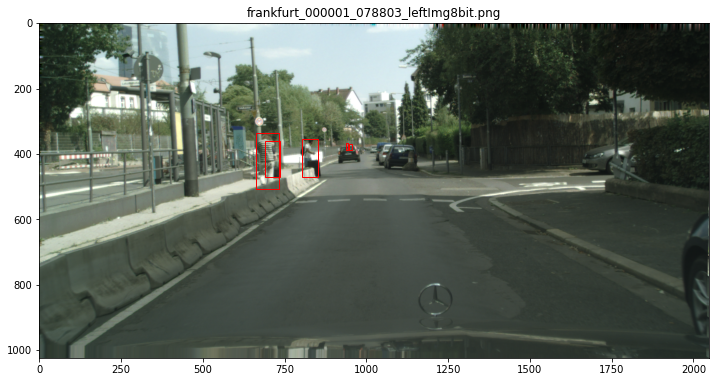

In [253]:
fig, ax = plt.subplots()
ax.imshow(img)

for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

In [254]:
img_np = np.array(img)
H, W = img_np.shape[:2]
H, W

(1024, 2048)

In [255]:
imgs_paths_train = [(imgs_path_train + img_name) for img_name in imgs_train]
imgs_paths_test = [(imgs_path_test + img_name) for img_name in imgs_test]

In [257]:
dataset = fasterrcnn.Dataset(imgs_paths_train, imgs_train, anno_train)
dataset_test = fasterrcnn.Dataset(imgs_paths_test, imgs_test, anno_test)

In [258]:
## test it
data = []
for i in range(10):
    data.append(dataset_test[i])

In [259]:
## test it
data = []
for i in range(10):
    data.append(dataset[i])

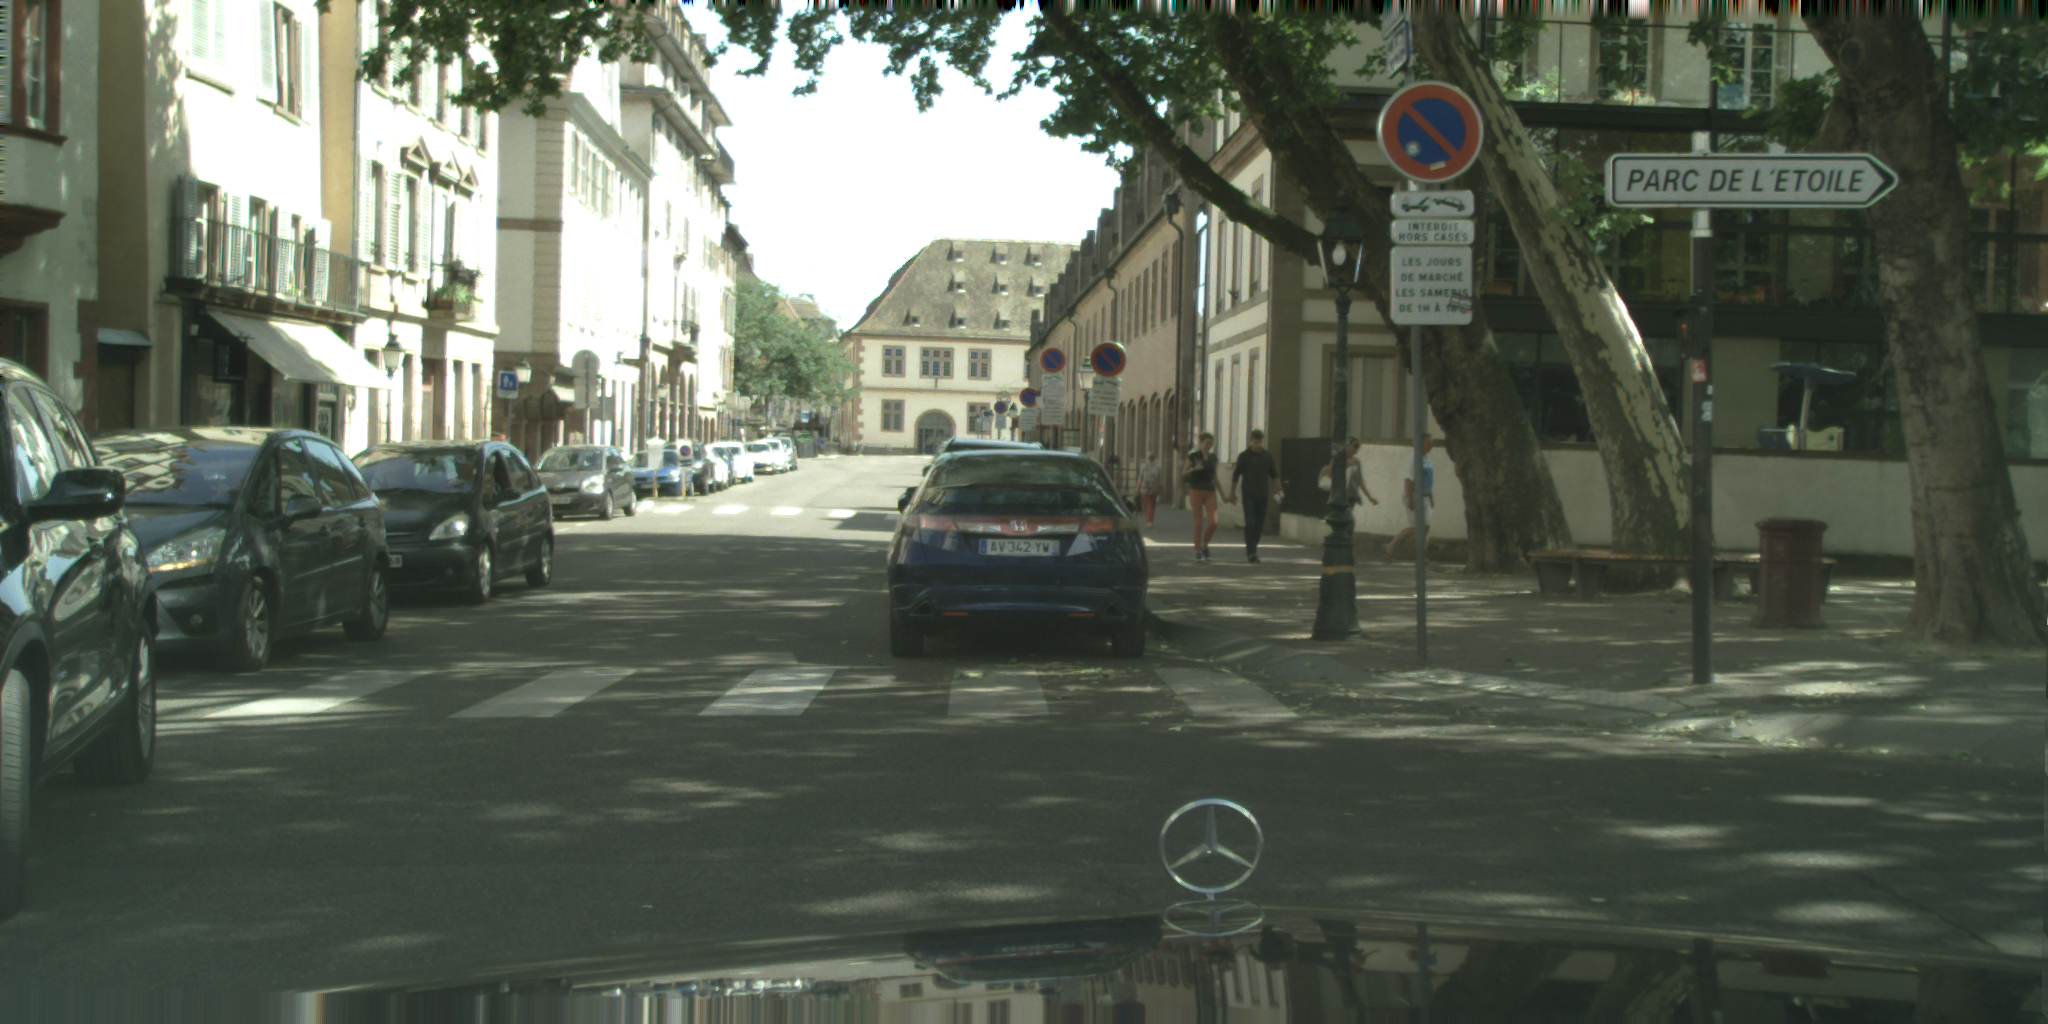

In [260]:
data[0][0]

## 3. Training

We do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster R-CNN model.

In [261]:
# split the dataset into train and test
dataset = fasterrcnn.Dataset(
    imgs_paths_train,
    imgs_train,
    anno_train, 
    fasterutils.get_transform(train=True))

dataset_test = fasterrcnn.Dataset(
    imgs_paths_test, 
    imgs_test,
    anno_test, 
    fasterutils.get_transform(train=False))

## permute the indices
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

In [1]:
## check the results
# print(len(indices), len(dataset_test))
# print(dataset[0],  dataset_test[0])

In [263]:
## define train and test sets
# dataset = torch.utils.data.Subset(dataset, indices[:-36])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-36:])

## define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [264]:
## check the results
print('Batch size = %d' % (data_loader.batch_size))
data_loader.dataset[0], data_loader_test.dataset[0]

Batch size = 2


((tensor([[[0.3412, 0.3529, 0.3647,  ..., 0.0000, 0.0000, 0.0000],
           [0.4510, 0.4471, 0.4392,  ..., 0.0000, 0.0000, 0.0000],
           [0.5804, 0.5647, 0.5529,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.2157, 0.2196, 0.2157,  ..., 0.1804, 0.1804, 0.1804],
           [0.2196, 0.2196, 0.2157,  ..., 0.1765, 0.1725, 0.1725],
           [0.2196, 0.2196, 0.2157,  ..., 0.1647, 0.1647, 0.1647]],
  
          [[0.3882, 0.4039, 0.4157,  ..., 0.0000, 0.1569, 0.0000],
           [0.4745, 0.4706, 0.4706,  ..., 0.0000, 0.1686, 0.0000],
           [0.6000, 0.5843, 0.5725,  ..., 0.0000, 0.1765, 0.0000],
           ...,
           [0.2745, 0.2784, 0.2745,  ..., 0.2196, 0.2196, 0.2196],
           [0.2745, 0.2784, 0.2745,  ..., 0.2157, 0.2157, 0.2157],
           [0.2745, 0.2784, 0.2745,  ..., 0.2118, 0.2118, 0.2118]],
  
          [[0.4000, 0.4039, 0.4078,  ..., 0.0000, 0.0745, 0.0000],
           [0.5255, 0.5137, 0.5020,  ..., 0.0000, 0.0824, 0.0000],
           [0.5922, 0.

In [265]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [266]:
model = fasterutils.get_model()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [267]:
# summary(model,input_size=(3,2048,1024))

In [286]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [287]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Let's train the model for 10 epochs, evaluating at the end of every epoch.

In [288]:
num_epochs = 10

tstart = time.time()
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
tend = time.time()

Epoch: [0]  [   0/1250]  eta: 0:14:16  lr: 0.000010  loss: 0.2760 (0.2760)  loss_classifier: 0.0981 (0.0981)  loss_box_reg: 0.1372 (0.1372)  loss_objectness: 0.0177 (0.0177)  loss_rpn_box_reg: 0.0230 (0.0230)  time: 0.6852  data: 0.5501  max mem: 2825
Epoch: [0]  [ 100/1250]  eta: 0:03:12  lr: 0.000509  loss: 0.3715 (0.4192)  loss_classifier: 0.0991 (0.1027)  loss_box_reg: 0.1496 (0.1642)  loss_objectness: 0.0344 (0.0512)  loss_rpn_box_reg: 0.0553 (0.1011)  time: 0.1616  data: 0.0472  max mem: 2825
Epoch: [0]  [ 200/1250]  eta: 0:02:50  lr: 0.001009  loss: 0.5698 (0.4482)  loss_classifier: 0.1441 (0.1129)  loss_box_reg: 0.2675 (0.1842)  loss_objectness: 0.0427 (0.0487)  loss_rpn_box_reg: 0.1085 (0.1024)  time: 0.1672  data: 0.0515  max mem: 2825
Epoch: [0]  [ 300/1250]  eta: 0:02:34  lr: 0.001508  loss: 0.4671 (0.4452)  loss_classifier: 0.1084 (0.1111)  loss_box_reg: 0.1921 (0.1822)  loss_objectness: 0.0399 (0.0488)  loss_rpn_box_reg: 0.0812 (0.1031)  time: 0.1761  data: 0.0612  max me

***Training time on Nvidia Tesla V100 with 16 GB memory***

In [289]:
print('Time elapsed = %.2f min' % ((tend - tstart)/60))

Time elapsed = 46.60 min


## 4. Error Analysis

### Ground truth

Select one image from test set with occlusions:

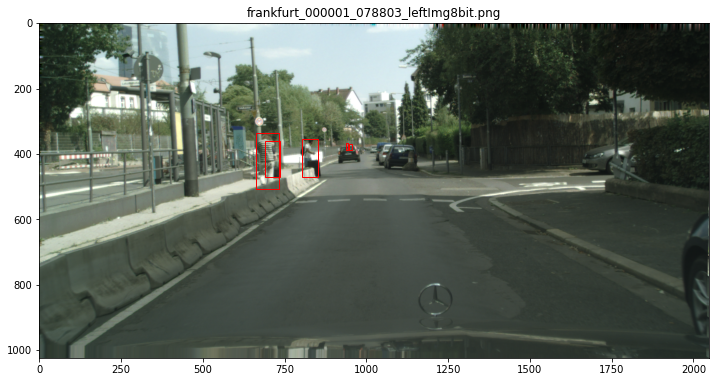

In [272]:
i = 0
img_name = imgs_test[i]
bboxes = anno_test[img_name]

img_path = imgs_path_test + img_name
img = Image.open(img_path)
np_image = np.array(img)

img_raw = img
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
plt.title('Pedestrians detected')
ax.imshow(img)
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

In [273]:
def convert_back(img, img_raw):
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    img = np.array(img)
    print('img shape: %d x %d x %d' % img.shape)
    img = Image.fromarray(np.uint8(img)).convert('RGB')

    img_flipped = np.array(img.transpose(Image.FLIP_LEFT_RIGHT))
    img_raw = np.array(img_raw)
    img_was_flipped = np.sum(img_flipped.flatten() == img_raw.flatten()) == img_flipped.shape[0] * img_flipped.shape[1] * img_flipped.shape[2]
    print('Image was flipped: %r' % img_was_flipped)
    
    return img

img shape: 1024 x 2048 x 3
Image was flipped: False


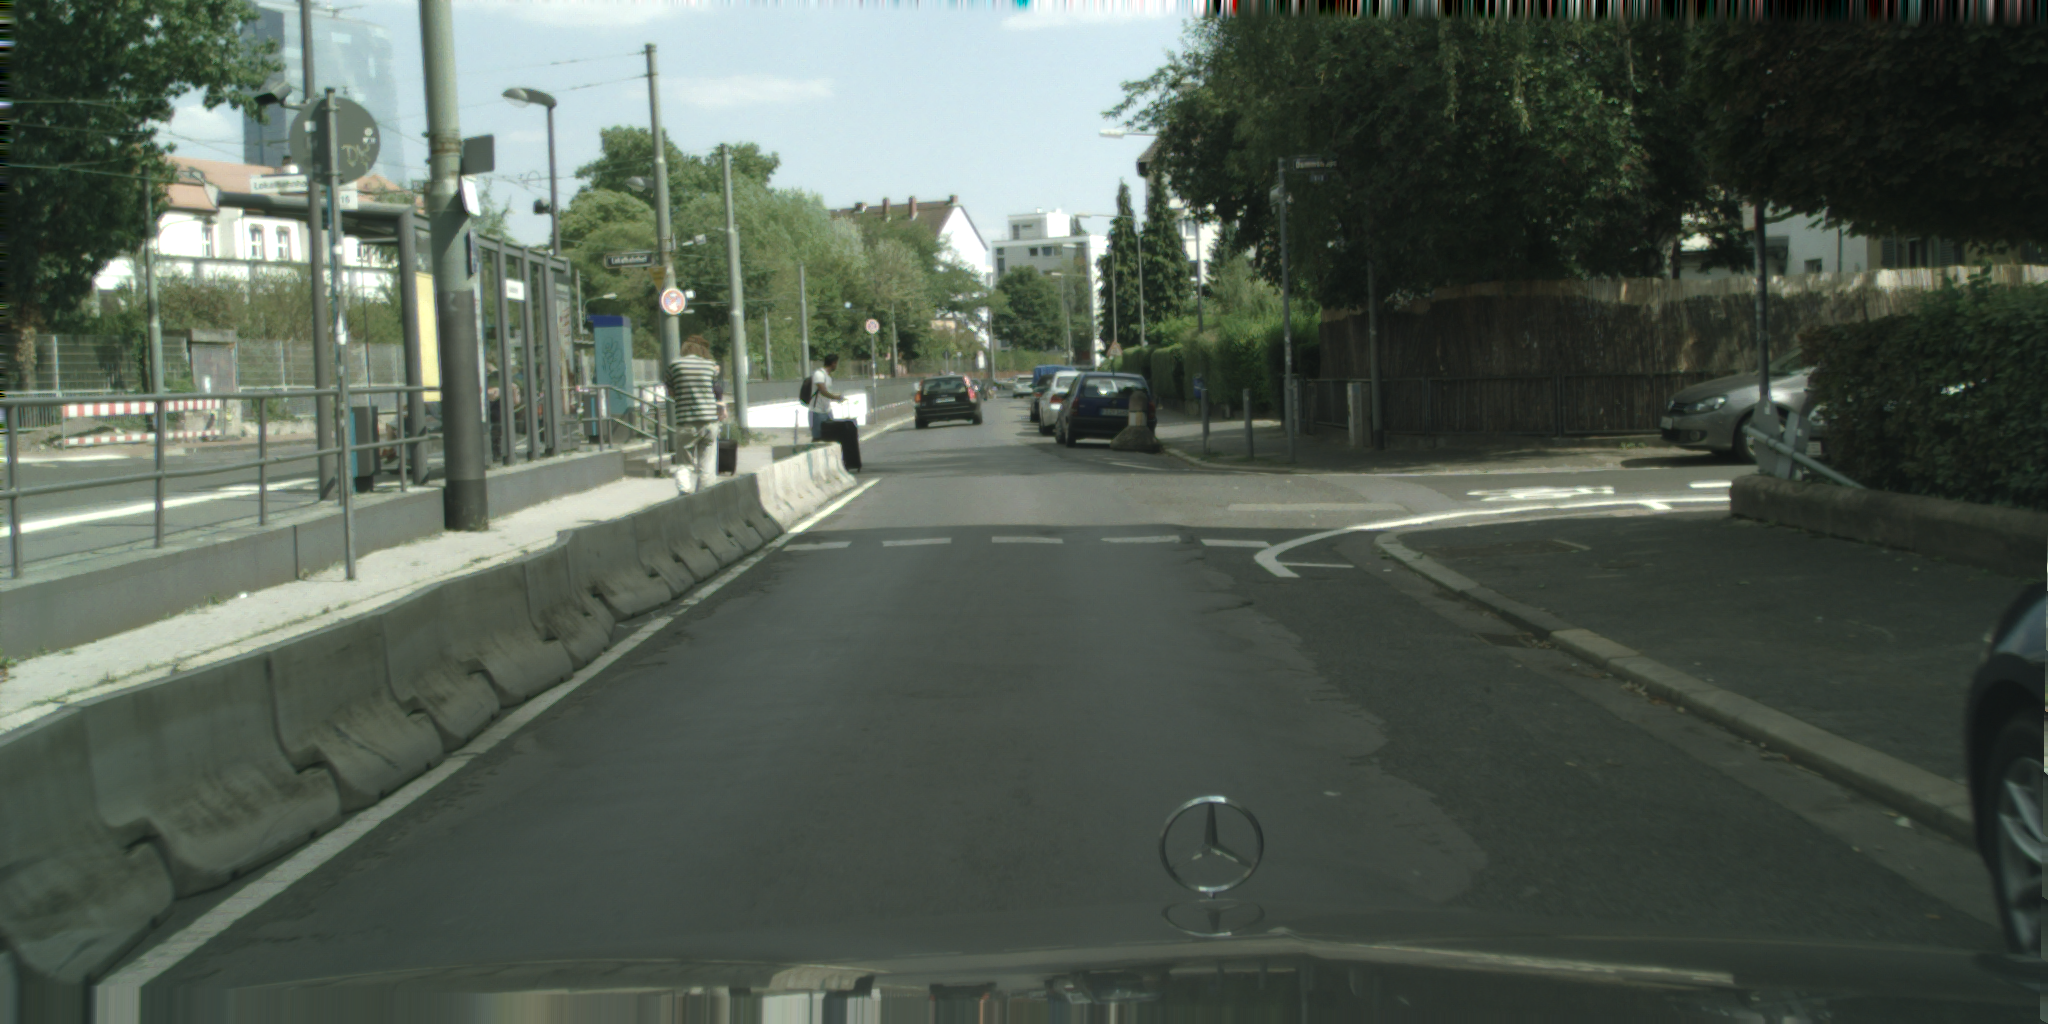

In [274]:
## check again
i = 0
img_name = imgs_test[i]
img_path = imgs_path_test + img_name
img_raw = Image.open(img_path)
img, anno = dataset_test[i]
convert_back(img, img_raw)

### Predicted

In [275]:
def show(i, imgs_test, threshold=.3):
    img_name = imgs_test[i]
    bboxes_gt = anno_test[img_name]

    img_path = imgs_path_test + img_name
    img = Image.open(img_path)
    np_image = np.array(img)
    img_raw = img

    ## idx = indices.index(i) # if on train set to unpermute
    img, anno = dataset_test[i]

    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        
    preds = prediction['boxes'] # predicted bboxes
    preds = preds.cpu().data.numpy() # to numpy array
    
    scores = prediction['scores'] # scores of predicted bboxes
    scores = scores.cpu().data.numpy()
    
    ## keep only bboxes where score > threshold:
    highs = list(np.where(scores > threshold)[0])
    
    img = convert_back(img, img_raw)

    bboxes_x0x1y0y1 = []
    for high in highs:
        bboxes_x0x1y0y1.append(list(preds[high]))
        
    ## transform the bboxes from tensor to list and back to [x, y, w, h] format
    ## transform back to [x, y, w, h] format
    bboxes = []
    for bbox in bboxes_x0x1y0y1:
        bbox = list(bbox)
        x0, y0 = bbox[0], bbox[1]
        x1, y1 = bbox[2], bbox[3]

        bboxes.append([x0, y0, x1 - x0, y1 - y0])
    
    ## draw the predicted bounding boxes    
    plt.rcParams['figure.figsize'] = [12, 8]

    fig, ax = plt.subplots()

    ax.imshow(img);

    # bbox = [x, y, w, h]
    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

    plt.title('Pedestrians detected')
    
    # bbox = [x, y, w, h]
    for bbox in bboxes_gt:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=1, edgecolor='g', facecolor='none')

        ax.add_patch(rect)    
    
    plt.show()

img shape: 1024 x 2048 x 3
Image was flipped: False


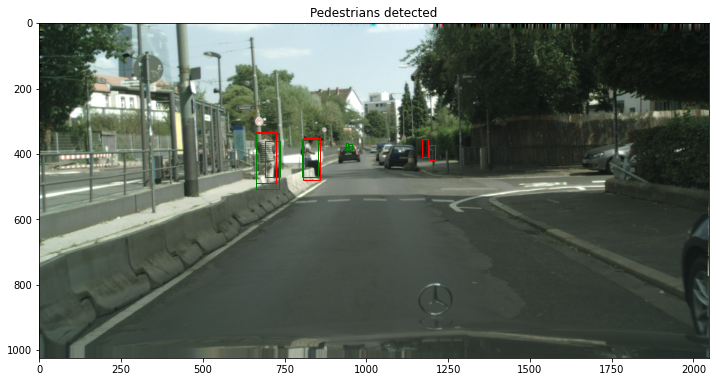

In [276]:
show(i, imgs_test, threshold=.3)

Results:

* Fit1:
```
Averaged stats: model_time: 0.0440 (0.0444)  evaluator_time: 0.0100 (0.0249)
Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.586
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.236
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.644
```

* Fit2:
```
Averaged stats: model_time: 0.0443 (0.0445)  evaluator_time: 0.0128 (0.0276)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.646
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
```

* Final fit (5 epochs):
```
Averaged stats: model_time: 0.0439 (0.0445)  evaluator_time: 0.0069 (0.0218)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.651
```

* Final fit (10 epochs):
```
Averaged stats: model_time: 0.0441 (0.0446)  evaluator_time: 0.0086 (0.0235)
Accumulating evaluation results...
DONE (t=0.27s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.668
```

## 5. Export

In [277]:
def save_model(model, path="./models/entire_model.pt"):
    torch.save(model, path)
    print('Model saved to ' + path)

In [278]:
save_model(model, path="../data/models/model-fit3.pt")

Model saved to ../data/models/model-fit3.pt




Detections first just to test, I made using model 

For first export of predictions I used the model I build on only 152 images from Aachen, which is a small subset of training set of Citypersons dataset. I had to test the training with complete test set of 500 images. I will train it on complete training set export predictions again soon. You can test your scripts on this.

For testing we are using Citypersons validation set of 500 images and corresponding annotations in particular 441 images where there are persons on the images. From cities: Munster, Frankfurt, Lindau. Let me know if you need image names

In [279]:
len(dataset_test), len(imgs_test)

(441, 441)

In [280]:
tstart = time.time()
# put the model in evaluation mode
model.eval()

predictions = {}
for i in range(len(dataset_test)):
    img, anno = dataset_test[i]

    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        predictions[imgs_test[i]] = prediction
        
    print('.', end = '')

tend = time.time()
print('\nExported %d predictions' % (len(predictions)))
print('\nTime elapsed = %.2f min' % ((tend - tstart)/60))

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................
Exported 441 predictions

Time elapsed = 1.15 min


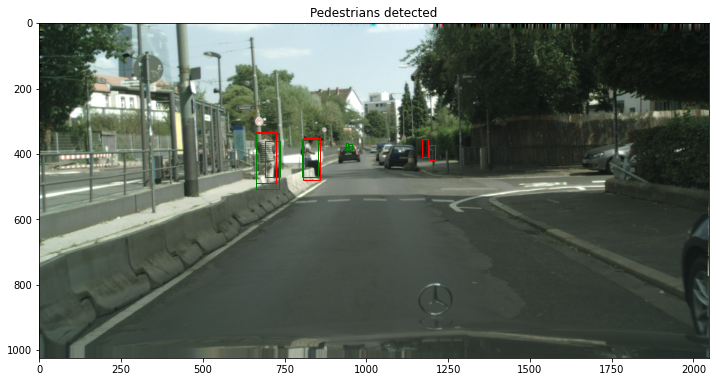

In [281]:
## final check
threshold = .3
i = 0

prediction = predictions[imgs_test[i]]
# preds
# pred['boxes'].cpu().data.numpy()

img_name = imgs_test[i]
bboxes_gt = anno_test[img_name]

img_path = imgs_path_test + img_name
img = Image.open(img_path)
np_image = np.array(img)
img_raw = img

preds = prediction['boxes'] # predicted bboxes
preds = preds.cpu().data.numpy() # to numpy array

scores = prediction['scores'] # scores of predicted bboxes
scores = scores.cpu().data.numpy()
    
## keep only bboxes where score > threshold:
highs = list(np.where(scores > threshold)[0])

bboxes_x0x1y0y1 = []
for high in highs:
    bboxes_x0x1y0y1.append(list(preds[high]))
        
## transform the bboxes from tensor to list and back to [x, y, w, h] format
## transform back to [x, y, w, h] format
bboxes = []
for bbox in bboxes_x0x1y0y1:
    bbox = list(bbox)
    x0, y0 = bbox[0], bbox[1]
    x1, y1 = bbox[2], bbox[3]

    bboxes.append([x0, y0, x1 - x0, y1 - y0])
    
## draw the predicted bounding boxes    
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()

ax.imshow(img);

## detections in red
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
    
plt.title('Pedestrians detected')
    
## ground truths in green
for bbox in bboxes_gt:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='g', facecolor='none')

    ax.add_patch(rect)    

plt.show()

In [282]:
## upack transform 
predictions2 = {}
for img in imgs_test:
    pred = predictions[img]
    boxes, labels, scores = pred['boxes'], pred['labels'], pred['scores']
    predictions2[img] = {
        'boxes': boxes.cpu().detach().numpy(),
        'labels': labels.cpu().detach().numpy(),
        'scores': scores.cpu().detach().numpy(),
    }

In [283]:
import pickle
with open(r"../data/predictions-fit3.pickle", "wb") as output_file:
    pickle.dump(predictions2, output_file)

In [284]:
predictions2[imgs_test[0]]

{'boxes': array([[ 662.8422 ,  333.23648,  724.67004,  489.5734 ],
        [ 804.9902 ,  351.8607 ,  857.18896,  478.32767],
        [1190.9387 ,  372.5352 , 1208.9575 ,  417.42972],
        [1168.5942 ,  354.90222, 1189.2792 ,  410.26035],
        [ 506.14056,  381.96063,  529.40564,  441.35327],
        [ 482.36337,  385.08633,  507.2187 ,  452.23398],
        [ 974.3028 ,  372.84573,  986.3778 ,  403.5369 ],
        [1666.2249 ,  244.87538, 1683.0969 ,  285.50778],
        [ 980.4713 ,  380.0943 ,  991.3689 ,  401.73987],
        [ 797.926  ,  359.9849 ,  840.6897 ,  459.0884 ],
        [1093.2878 ,  349.7019 , 1113.2712 ,  400.63788],
        [1106.1025 ,  339.00433, 1123.4646 ,  380.41708],
        [1100.2612 ,  338.5715 , 1117.2216 ,  374.12656],
        [ 961.02277,  372.21182,  975.7608 ,  409.11932],
        [1100.98   ,  349.47116, 1121.0948 ,  401.87943],
        [ 969.98114,  373.68027,  982.4322 ,  404.15237],
        [1093.0094 ,  340.18192, 1110.3083 ,  370.44778],
     

In [285]:
predictions2[imgs_test[1]]

{'boxes': array([[ 807.6329 ,  343.27094,  890.54095,  541.85565],
        [ 890.9647 ,  356.02332,  969.51465,  556.47705],
        [ 474.9681 ,  386.52133,  507.82343,  469.51187],
        [ 827.70087,  346.0721 ,  930.8689 ,  561.2693 ],
        [ 485.3781 ,  386.30475,  511.11487,  445.50436],
        [ 484.03607,  340.01706,  505.17908,  391.65332],
        [ 424.89105,  379.37683,  444.8973 ,  429.67422],
        [ 464.28568,  389.54422,  518.2076 ,  505.72626],
        [1025.3784 ,  389.18253, 1042.268  ,  429.142  ],
        [ 741.1415 ,  326.30078,  795.6432 ,  454.52313],
        [ 892.6991 ,  381.67633,  940.414  ,  509.3583 ],
        [1015.54474,  388.00772, 1036.6201 ,  438.29373],
        [1011.90265,  386.93658, 1030.1705 ,  427.48602],
        [ 936.6248 ,  397.043  ,  973.863  ,  492.2272 ],
        [1032.6469 ,  386.47656, 1053.1163 ,  437.26135],
        [1633.1798 ,  376.05768, 1682.7677 ,  507.09323],
        [ 406.62244,  418.8006 ,  430.04385,  476.8751 ],
     